In [1]:
__depends__ = [
    "../../../data/database-results/phase-1/timestamp.txt",
    "../../../data/database-observations/timestamp.txt",
]
__dest__ = [
    "../../../figures/rcp-ssp-comparison.pdf",
    "../../../figures/rcp-ssp-emissions-comparison.pdf",
]

In [2]:
TAS_COMPARISON_FIGURE_PDF = __dest__[0]
EMMS_COMPARISON_FIGURE_PDF = __dest__[1]

In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# RCP SSP comparisons

In [4]:
import glob
import logging

import os

import re
from pathlib import Path

import numpy as np
import pandas as pd

import tqdm.autonotebook as tqdman

from pymagicc.io import MAGICCData
from scmdata import ScmRun, ScmDataFrame
from scmdata.run import df_append

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.gridspec as gridspec
import seaborn as sns

%matplotlib inline

/Users/znicholls/miniconda3/envs/rcmip/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if sys.path[0] == '':


<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


<IPython.core.display.Javascript object>

In [36]:
from utils import (
    aggregate_effective_aerosol_forcing,
    clean_labels,
    convert_scmdf_to_pyamdf_year_only,
    load_database_files,
    prep_str_for_filename,
    reduce_to_one_variant_per_model,
)

<IPython.core.display.Javascript object>

In [6]:
logger = logging.getLogger()

<IPython.core.display.Javascript object>

In [7]:
PYAM_COLORS = {
    # AR6 colours from https://github.com/IPCC-WG1/colormaps
    # where each file is processed to generate hex values, e.g.:
    # for liwith open('rcp_cat.txt') as f:
    #   for l in f.readlines():
    #     rgb = np.array([int(x) for x in l.strip().split()]) / 256
    #     print(matplotlib.colors.rgb2hex(rgb))
    "AR6-SSP1": "#1e9583",
    "AR6-SSP2": "#4576be",
    "AR6-SSP3": "#f11111",
    "AR6-SSP4": "#e78731",
    "AR6-SSP5": "#8036a7",
    "AR6-SSP1-1.9": "#1e9583",
    "AR6-SSP1-2.6": "#1d3354",
    "AR6-SSP2-4.5": "#e9dc3d",
    "AR6-SSP3-7.0": "#f11111",
    "AR6-SSP3-LowNTCF": "#f11111",
    "AR6-SSP4-3.4": "#63bce4",
    "AR6-SSP4-6.0": "#e78731",
    "AR6-SSP5-3.4-OS": "#996dc8",
    "AR6-SSP5-8.5": "#830b22",
    "AR6-RCP-2.6": "#980002",
    "AR6-RCP-4.5": "#c37900",
    "AR6-RCP-6.0": "#709fcc",
    "AR6-RCP-8.5": "#003466",
    # AR5 colours from
    # https://tdaviesbarnard.co.uk/1202/ipcc-official-colors-rcp/
    "AR5-RCP-2.6": "#0000FF",
    "AR5-RCP-4.5": "#79BCFF",
    "AR5-RCP-6.0": "#FF822D",
    "AR5-RCP-8.5": "#FF0000",
}

color_map_scenarios_base = {
    "ssp119": "AR6-SSP1-1.9",
    "ssp126": "AR6-SSP1-2.6",
    "ssp245": "AR6-SSP2-4.5",
    "ssp370": "AR6-SSP3-7.0",
    "ssp370-lowNTCF": "AR6-SSP3-LowNTCF",
    "ssp370-lowNTCF-gidden": "AR6-SSP3-LowNTCF",
    "ssp370-lowNTCF-aerchemmip": "AR6-SSP3-LowNTCF",
    "ssp434": "AR6-SSP4-3.4",
    "ssp460": "AR6-SSP4-6.0",
    "ssp585": "AR6-SSP5-8.5",
    "ssp534-over": "AR6-SSP5-3.4-OS",
    "historical": "black",
    "rcp26": "AR5-RCP-2.6",
    "rcp45": "AR5-RCP-4.5",
    "rcp60": "AR5-RCP-6.0",
    "rcp85": "AR5-RCP-8.5",
    "historical-cmip5": "tab:gray",
}

color_map_scenarios = {}
for k, v in color_map_scenarios_base.items():
    try:
        color_map_scenarios[k] = PYAM_COLORS[v]
        color_map_scenarios["esm-{}".format(k)] = PYAM_COLORS[v]
        color_map_scenarios["esm-{}-allGHG".format(k)] = PYAM_COLORS[v]
    except KeyError:
        color_map_scenarios[k] = v
        color_map_scenarios["esm-{}".format(k)] = v
        color_map_scenarios["esm-{}-allGHG".format(k)] = v

<IPython.core.display.Javascript object>

In [8]:
color_map_scenarios_hex = {}
for k, v in color_map_scenarios.items():
    try:
        color_map_scenarios_hex[k] = PYAM_COLORS[v]
    except KeyError:
        color_map_scenarios_hex[k] = v

color_map_scenarios_hex

{'ssp119': '#1e9583',
 'esm-ssp119': '#1e9583',
 'esm-ssp119-allGHG': '#1e9583',
 'ssp126': '#1d3354',
 'esm-ssp126': '#1d3354',
 'esm-ssp126-allGHG': '#1d3354',
 'ssp245': '#e9dc3d',
 'esm-ssp245': '#e9dc3d',
 'esm-ssp245-allGHG': '#e9dc3d',
 'ssp370': '#f11111',
 'esm-ssp370': '#f11111',
 'esm-ssp370-allGHG': '#f11111',
 'ssp370-lowNTCF': '#f11111',
 'esm-ssp370-lowNTCF': '#f11111',
 'esm-ssp370-lowNTCF-allGHG': '#f11111',
 'ssp370-lowNTCF-gidden': '#f11111',
 'esm-ssp370-lowNTCF-gidden': '#f11111',
 'esm-ssp370-lowNTCF-gidden-allGHG': '#f11111',
 'ssp370-lowNTCF-aerchemmip': '#f11111',
 'esm-ssp370-lowNTCF-aerchemmip': '#f11111',
 'esm-ssp370-lowNTCF-aerchemmip-allGHG': '#f11111',
 'ssp434': '#63bce4',
 'esm-ssp434': '#63bce4',
 'esm-ssp434-allGHG': '#63bce4',
 'ssp460': '#e78731',
 'esm-ssp460': '#e78731',
 'esm-ssp460-allGHG': '#e78731',
 'ssp585': '#830b22',
 'esm-ssp585': '#830b22',
 'esm-ssp585-allGHG': '#830b22',
 'ssp534-over': '#996dc8',
 'esm-ssp534-over': '#996dc8',
 'esm-

<IPython.core.display.Javascript object>

In [9]:
color_map_models = {
    "Cicero-SCM": "red",
    "Cicero-SCM-ECS3": "darkmagenta",
    "FaIR-1.5-DEFAULT": "green",
    "FaIR-1.5-ENS": "greenyellow",
    "GIR (3 box)": "brown",
    "GREB-v1.0.1-ECMWF_IFS-ALL": "darkgrey",
    "MAGICC7.1.0aX-rcmip-phase-1": "dodgerblue",
    "hector|62381e71|DEFAULT": "purple",
    "hector|62381e71|HISTCALIB": "blueviolet",
}

<IPython.core.display.Javascript object>

## Load data

### Observations

In [10]:
OBS_PATH = os.path.join("..", "..", "..", "data", "database-observations")
OBS_PATH

'../../../data/database-observations'

<IPython.core.display.Javascript object>

In [11]:
db_obs = df_append(
    [ScmRun.from_nc(f) for f in glob.glob(os.path.join(OBS_PATH, "*.nc"))]
)
db_obs.timeseries().head()

time                                                                                               1850-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K      -0.042412   

time                                                                                               1851-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K       0.123588   

time                                                                                               1852-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K       0.085588   

time                                                                                               1853-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K       0.025588   

time                                                                                               1854-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K       0.086588   

time                                                                                               1855-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K       0.087588   

time                                                                                               1856-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K      -0.040412   

time                                                                                               1857-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K      -0.138412   

time                                                                                               1858-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K      -0.074412   

time                                                                                               1859-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K      -0.012412   

time                                                                                               ...  \
region model       scenario   climatemodel                    variable                       unit  ...   
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K     ...   

time                                                                                               2009-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley C

<IPython.core.display.Javascript object>

### RCMIP inputs

In [12]:
SCENARIO_PROTOCOL = os.path.join(
    "..", "..", "..", "data", "protocol", "rcmip-emissions-annual-means-v3-1-0.csv"
)
SCENARIO_PROTOCOL

'../../../data/protocol/rcmip-emissions-annual-means-v3-1-0.csv'

<IPython.core.display.Javascript object>

In [13]:
db_protocol = ScmDataFrame(SCENARIO_PROTOCOL)
db_protocol.head()

/Users/znicholls/miniconda3/envs/rcmip/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: ScmDataFrame has been deprecated and will be removed in v0.6.0. Use the ScmRun class instead
  """Entry point for launching an IPython kernel.


time                                                                               1750-01-01 00:00:00  \
model scenario region variable                   unit      activity_id    mip_era                        
AIM   rcp60    World  Emissions|BC               Mt BC/yr  not_applicable CMIP5                    NaN   
                      Emissions|CH4              Mt CH4/yr not_applicable CMIP5                    NaN   
                      Emissions|CO               Mt CO/yr  not_applicable CMIP5                    NaN   
                      Emissions|CO2              Mt CO2/yr not_applicable CMIP5                    NaN   
                      Emissions|CO2|MAGICC AFOLU Mt CO2/yr not_applicable CMIP5                    NaN   

time                                                                               1751-01-01 00:00:00  \
model scenario region variable                   unit      activity_id    mip_era                        
AIM   rcp60    World  Emissions|BC               Mt BC/yr  not_applicable CMIP5                    NaN   
                      Emissions|CH4              Mt CH4/yr not_applicable CMIP5                    NaN   
                      Emissions|CO               Mt CO/yr  not_applicable CMIP5                    NaN   
                      Emissions|CO2              Mt CO2/yr not_applicable CMIP5                    NaN   
                      Emissions|CO2|MAGICC AFOLU Mt CO2/yr not_applicable CMIP5                    NaN   

time                                                                               1752-01-01 00:00:00  \
model scenario region variable                   unit      activity_id    mip_era                        
AIM   rcp60    World  Emissions|BC               Mt BC/yr  not_applicable CMIP5                    NaN   
                      Emissions|CH4              Mt CH4/yr not_applicable CMIP5                    NaN   
                      Emissions|CO               Mt CO/yr  not_applicable CMIP5                    NaN   
                      Emissions|CO2              Mt CO2/yr not_applicable CMIP5                    NaN   
                      Emissions|CO2|MAGICC AFOLU Mt CO2/yr not_applicable CMIP5                    NaN   

time                                                                               1753-01-01 00:00:00  \
model scenario region variable                   unit      activity_id    mip_era                        
AIM   rcp60    World  Emissions|BC               Mt BC/yr  not_applicable CMIP5                    NaN   
                      Emissions|CH4              Mt CH4/yr not_applicable CMIP5                    NaN   
                      Emissions|CO               Mt CO/yr  not_applicable CMIP5                    NaN   
                      Emissions|CO2              Mt CO2/yr not_applicable CMIP5                    NaN   
                      Emissions|CO2|MAGICC AFOLU Mt CO2/yr not_applicable CMIP5                    NaN   

time                                                                               1754-01-01 00:00:00  \
model scenario region variable                   unit      activity_id    mip_era                        
AIM   rcp60    World  Emissions|BC               Mt BC/yr  not_applicable CMIP5                    NaN   
                      Emissions|CH4              Mt CH4/yr not_applicable CMIP5                    NaN   
                      Emissions|CO               Mt CO/yr  not_applicable CMIP5                    NaN   
                      Emissions|CO2              Mt CO2/yr not_applicable CMIP5                    NaN   
                      Emissions|CO2|MAGICC AFOLU Mt CO2/yr not_applicable CMIP5                    NaN   

time                                                                               1755-01-01 00:00:00  \
model scenario region variable                   unit      activity_id    mip_era                        
AIM   rcp60    World  Emissions|BC               Mt BC/yr  not_applicable

<IPython.core.display.Javascript object>

### RCMIP results

In [14]:
RESULTS_PATH = os.path.join("..", "..", "..", "data", "database-results", "phase-1")
RESULTS_PATH

'../../../data/database-results/phase-1'

<IPython.core.display.Javascript object>

In [15]:
model_of_interest = [
    ".*acc2.*",
    ".*ar5ir.*",
    ".*cicero-scm.*",
    ".*escimo.*",
    ".*fair-1.5.*",
    ".*gir.*",
    ".*greb.*",
    ".*hector.*",
    ".*held.*",
    ".*magicc7.*",
    ".*mce.*",
    ".*oscar.*",
    ".*wasp.*",
]

results_files = list(Path(RESULTS_PATH).rglob("*.nc"))
results_files = [
    str(p)
    for p in results_files
    if any([bool(re.match(m, str(p))) for m in model_of_interest]) and "$" not in str(p)
]
print("Number of available files: {}".format(len(results_files)))
results_files[:5]

Number of available files: 10119


['../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm-ecs3_world_effective-radiative-forcing-anthropogenic-f-gases-pfc-cf4.nc',
 '../../../data/database-results/phase-1/rcmip-phase-1_magicc7.1.0.beta-mpi-esm1-2-hr-r1i1p1f1_world_emissions-f-gases-hfc-hfc125.nc',
 '../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm-ecs3_world_radiative-forcing-anthropogenic-tropospheric-ozone.nc',
 '../../../data/database-results/phase-1/rcmip-phase-1_magicc7.1.0.beta-bcc-esm1-r1i1p1f1_world_radiative-forcing-anthropogenic-aerosols-aerosols-radiation-interactions.nc',
 '../../../data/database-results/phase-1/rcmip-phase-1_fair-1.5-ens_world_atmospheric-concentrations-f-gases-pfc-cf4-50th-quantile.nc']

<IPython.core.display.Javascript object>

In [16]:
variables_of_interest = [
    "surface-air-temperature-change",
    #     "Surface Ocean Temperature Change",
    #     "Surface Air Ocean Blended Temperature Change",
    "effective-radiative-forcing(-\d|.nc)",
    "effective-radiative-forcing-anthropogenic-co2",
    "effective-radiative-forcing-anthropogenic-aerosols",
    "effective-radiative-forcing-anthropogenic-other",
]

relevant_files = [
    str(p)
    for p in results_files
    if any([bool(re.match(".*{}.*".format(v), str(p))) for v in variables_of_interest])
]
print("Number of relevant files: {}".format(len(relevant_files)))
relevant_files[:5]

Number of relevant files: 969


['../../../data/database-results/phase-1/rcmip-phase-1_wasp,2,prob-ecs3_world_effective-radiative-forcing-5th-quantile.nc',
 '../../../data/database-results/phase-1/rcmip-phase-1_fair-1.5-ens_world_effective-radiative-forcing-anthropogenic-other-other-wmghgs-50th-quantile.nc',
 '../../../data/database-results/phase-1/rcmip-phase-1_magicc7.1.0.beta-ipsl-cm6a-lr-r1i1p1f2_world_effective-radiative-forcing-anthropogenic-aerosols-aerosols-radiation-interactions-nh3-fossil-and-industrial.nc',
 '../../../data/database-results/phase-1/rcmip-phase-1_fair-1.5-ens_world_effective-radiative-forcing-anthropogenic-aerosols-aerosols-cloud-interactions-50th-quantile.nc',
 '../../../data/database-results/phase-1/rcmip-phase-1_ar5ir3box-cmip6-bcc-esm1-r1i1p1f1-calib_world_effective-radiative-forcing-anthropogenic-co2.nc']

<IPython.core.display.Javascript object>

In [17]:
logging.getLogger("scmdata").setLevel(logging.WARNING)
db = load_database_files(relevant_files)
logging.getLogger("scmdata").setLevel(logging.INFO)
db.head()

time                                                                                                            1750-01-01 00:00:00  \
region model       scenario       climatemodel     variable                                 unit_context unit                         
World  unspecified 1pctCO2        WASP,2,PROB-ECS3 Effective Radiative Forcing|5th quantile not_required W/m^2                  NaN   
                   1pctCO2-4xext  WASP,2,PROB-ECS3 Effective Radiative Forcing|5th quantile not_required W/m^2                  NaN   
                   abrupt-0p5xCO2 WASP,2,PROB-ECS3 Effective Radiative Forcing|5th quantile not_required W/m^2                  NaN   
                   abrupt-2xCO2   WASP,2,PROB-ECS3 Effective Radiative Forcing|5th quantile not_required W/m^2                  NaN   
                   abrupt-4xCO2   WASP,2,PROB-ECS3 Effective Radiative Forcing|5th quantile not_required W/m^2                  NaN   

time                                                                                                            1751-01-01 00:00:00  \
region model       scenario       climatemodel     variable                                 unit_context unit                         
World  unspecified 1pctCO2        WASP,2,PROB-ECS3 Effective Radiative Forcing|5th quantile not_required W/m^2                  NaN   
                   1pctCO2-4xext  WASP,2,PROB-ECS3 Effective Radiative Forcing|5th quantile not_required W/m^2                  NaN   
                   abrupt-0p5xCO2 WASP,2,PROB-ECS3 Effective Radiative Forcing|5th quantile not_required W/m^2                  NaN   
                   abrupt-2xCO2   WASP,2,PROB-ECS3 Effective Radiative Forcing|5th quantile not_required W/m^2                  NaN   
                   abrupt-4xCO2   WASP,2,PROB-ECS3 Effective Radiative Forcing|5th quantile not_required W/m^2                  NaN   

time                                                                                                            1752-01-01 00:00:00  \
region model       scenario       climatemodel     variable                                 unit_context unit                         
World  unspecified 1pctCO2        WASP,2,PROB-ECS3 Effective Radiative Forcing|5th quantile not_required W/m^2                  NaN   
                   1pctCO2-4xext  WASP,2,PROB-ECS3 Effective Radiative Forcing|5th quantile not_required W/m^2                  NaN   
                   abrupt-0p5xCO2 WASP,2,PROB-ECS3 Effective Radiative Forcing|5th quantile not_required W/m^2                  NaN   
                   abrupt-2xCO2   WASP,2,PROB-ECS3 Effective Radiative Forcing|5th quantile not_required W/m^2                  NaN   
                   abrupt-4xCO2   WASP,2,PROB-ECS3 Effective Radiative Forcing|5th quantile not_required W/m^2                  NaN   

time                                                                                                            1753-01-01 00:00:00  \
region model       scenario       climatemodel     variable                                 unit_context unit                         
World  unspecified 1pctCO2        WASP,2,PROB-ECS3 Effective Radiative Forcing|5th quantile not_required W/m^2                  NaN   
                   1pctCO2-4xext  WASP,2,PROB-ECS3 Effective Radiative Forcing|5th quantile not_required W/m^2                  NaN   
                   abrupt-0p5xCO2 WASP,2,PROB-ECS3 Effective Radiative Forcing|5th quantile not_required W/m^2                  NaN   
                   abrupt-2xCO2   WASP,2,PROB-ECS3 Effective Radiative Forcing|5th quantile not_required W/m^2                  NaN   
                   abrupt-4xCO2   WASP,2,PROB-ECS3 Effective Radiative Forcing|5th quantile not_required W/m^2                  NaN   

time                                                                                                            1754-01-01 00:00:00  \
region model       scenario       climatemodel     variable                      

<IPython.core.display.Javascript object>

In [18]:
db["variable"].unique()

array(['Effective Radiative Forcing|5th quantile',
       'Effective Radiative Forcing|Anthropogenic|Other|Other WMGHGs|50th quantile',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|NH3|Fossil and Industrial',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-cloud Interactions|50th quantile',
       'Effective Radiative Forcing|Anthropogenic|CO2',
       'Surface Air Temperature Change', 'Effective Radiative Forcing',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|Other|16th quantile',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|Fossil and Industrial|Nitrate',
       'Effective Radiative Forcing|Anthropogenic|Other|CH4 Oxidation Stratospheric H2O|33th quantile',
       'Surface Air Temperature Change|97.5th quantile',
       'Surface Air Temperature Change|17th quantile',
       'Effective Radiative Forcing|Anthropogenic|Other|Other 

<IPython.core.display.Javascript object>

## Plot

/Users/znicholls/miniconda3/envs/rcmip/lib/python3.7/site-packages/scmdata/dataframe.py:507: UserWarning: Ignoring time_axis value. Use the ScmRun class instead
  warnings.warn("Ignoring time_axis value. Use the ScmRun class instead")
/Users/znicholls/miniconda3/envs/rcmip/lib/python3.7/site-packages/scmdata/dataframe.py:507: UserWarning: Ignoring time_axis value. Use the ScmRun class instead
  warnings.warn("Ignoring time_axis value. Use the ScmRun class instead")
/Users/znicholls/miniconda3/envs/rcmip/lib/python3.7/site-packages/scmdata/dataframe.py:507: UserWarning: Ignoring time_axis value. Use the ScmRun class instead
  warnings.warn("Ignoring time_axis value. Use the ScmRun class instead")
/Users/znicholls/miniconda3/envs/rcmip/lib/python3.7/site-packages/scmdata/dataframe.py:507: UserWarning: Ignoring time_axis value. Use the ScmRun class instead
  warnings.warn("Ignoring time_axis value. Use the ScmRun class instead")


/Users/znicholls/miniconda3/envs/rcmip/lib/python3.7/site-packages/scmdata/dataframe.py:507: UserWarning: Ignoring time_axis value. Use the ScmRun class instead
  warnings.warn("Ignoring time_axis value. Use the ScmRun class instead")
/Users/znicholls/miniconda3/envs/rcmip/lib/python3.7/site-packages/scmdata/dataframe.py:507: UserWarning: Ignoring time_axis value. Use the ScmRun class instead
  warnings.warn("Ignoring time_axis value. Use the ScmRun class instead")
/Users/znicholls/miniconda3/envs/rcmip/lib/python3.7/site-packages/scmdata/dataframe.py:507: UserWarning: Ignoring time_axis value. Use the ScmRun class instead
  warnings.warn("Ignoring time_axis value. Use the ScmRun class instead")
/Users/znicholls/miniconda3/envs/rcmip/lib/python3.7/site-packages/scmdata/dataframe.py:507: UserWarning: Ignoring time_axis value. Use the ScmRun class instead
  warnings.warn("Ignoring time_axis value. Use the ScmRun class instead")


/Users/znicholls/miniconda3/envs/rcmip/lib/python3.7/site-packages/scmdata/dataframe.py:507: UserWarning: Ignoring time_axis value. Use the ScmRun class instead
  warnings.warn("Ignoring time_axis value. Use the ScmRun class instead")
/Users/znicholls/miniconda3/envs/rcmip/lib/python3.7/site-packages/scmdata/dataframe.py:507: UserWarning: Ignoring time_axis value. Use the ScmRun class instead
  warnings.warn("Ignoring time_axis value. Use the ScmRun class instead")
/Users/znicholls/miniconda3/envs/rcmip/lib/python3.7/site-packages/scmdata/dataframe.py:507: UserWarning: Ignoring time_axis value. Use the ScmRun class instead
  warnings.warn("Ignoring time_axis value. Use the ScmRun class instead")
/Users/znicholls/miniconda3/envs/rcmip/lib/python3.7/site-packages/scmdata/dataframe.py:507: UserWarning: Ignoring time_axis value. Use the ScmRun class instead
  warnings.warn("Ignoring time_axis value. Use the ScmRun class instead")


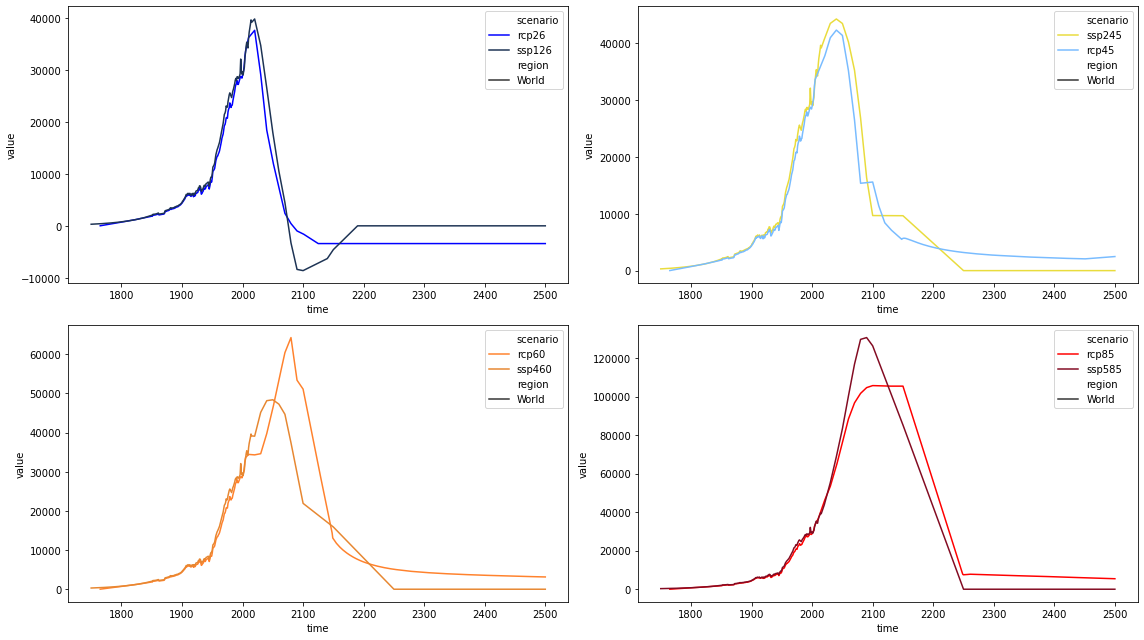

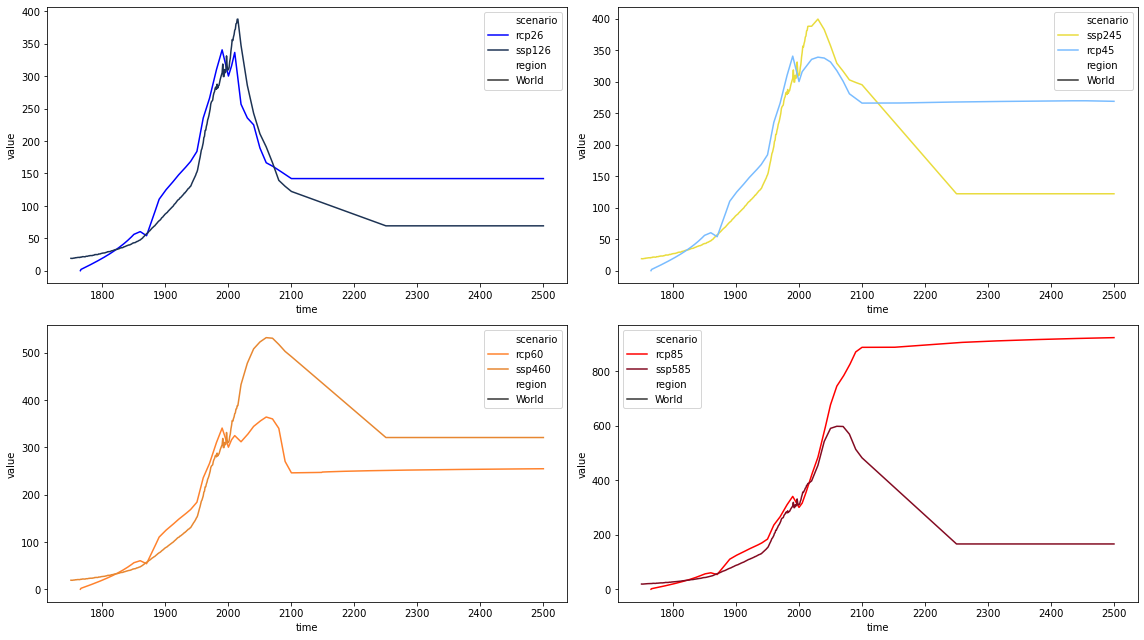

<IPython.core.display.Javascript object>

In [19]:
filters_variables = [["Emissions|CO2"], ["Emissions|CH4"], ["Emissions|Sulfur"]]
filters_scenario = [
    ["rcp26", "ssp126"],
    ["rcp45", "ssp245"],
    ["rcp60", "ssp460"],
    ["rcp85", "ssp585"],
]
region = ["World"]

pdf_to_save = matplotlib.backends.backend_pdf.PdfPages(EMMS_COMPARISON_FIGURE_PDF)

for filter_var in tqdman.tqdm(filters_variables, desc="Variable"):
    fig = plt.figure(figsize=(16, 9))
    axes = [
        fig.add_subplot(221),
        fig.add_subplot(222),
        fig.add_subplot(223),
        fig.add_subplot(224),
    ]
    for filter_scen, ax in tqdman.tqdm(zip(filters_scenario, axes), leave=False):
        pdf = db_protocol.filter(
            variable=filter_var, region=region, scenario=filter_scen
        )

        pdf.lineplot(
            time_axis="year",
            hue="scenario",
            ax=ax,
            style="region",
            palette=color_map_scenarios,
        )

    plt.tight_layout()
    pdf_to_save.savefig(fig)

pdf_to_save.close()

In [20]:
db = aggregate_effective_aerosol_forcing(db)
db.filter(variable="*Aerosols")["variable"].unique()

Filtered ScmRun is empty!
/Users/znicholls/Documents/AGCEC/RCMIP/rcmip/notebooks/results/phase-1/utils.py:51: UserWarning: No Effective Radiative Forcing|Anthropogenic|Aerosols data for OSCARv3.0
  warnings.warn("No {} data for {}".format(var_to_agg, cm))
Filtered ScmRun is empty!
Filtered ScmRun is empty!


array(['Effective Radiative Forcing|Anthropogenic|Aerosols',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|Other|Secondary Organic Aerosols'],
      dtype=object)

<IPython.core.display.Javascript object>

In [21]:
db["variable"].unique()

array(['Effective Radiative Forcing|5th quantile',
       'Effective Radiative Forcing|Anthropogenic|Other|Other WMGHGs|50th quantile',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|NH3|Fossil and Industrial',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-cloud Interactions|50th quantile',
       'Effective Radiative Forcing|Anthropogenic|CO2',
       'Surface Air Temperature Change', 'Effective Radiative Forcing',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|Other|16th quantile',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|Fossil and Industrial|Nitrate',
       'Effective Radiative Forcing|Anthropogenic|Other|CH4 Oxidation Stratospheric H2O|33th quantile',
       'Surface Air Temperature Change|97.5th quantile',
       'Surface Air Temperature Change|17th quantile',
       'Effective Radiative Forcing|Anthropogenic|Other|Other 

<IPython.core.display.Javascript object>

In [22]:
sorted(db.filter(variable="*Aerosols*")["climatemodel"].unique())

['Cicero-SCM',
 'Cicero-SCM-ECS3',
 'ESCIMO,rcmip,base',
 'FaIR-1.5-DEFAULT',
 'FaIR-1.5-ENS',
 'GIR (3 box)',
 'MAGICC7.1.0.beta-rcmip-phase-1',
 'MAGICC7.1.0.beta_AWI-CM-1-1-MR_R1I1P1F1',
 'MAGICC7.1.0.beta_BCC-CSM2-MR_R1I1P1F1',
 'MAGICC7.1.0.beta_BCC-ESM1_R1I1P1F1',
 'MAGICC7.1.0.beta_CANESM5_R10I1P1F1',
 'MAGICC7.1.0.beta_CANESM5_R1I1P1F1',
 'MAGICC7.1.0.beta_CANESM5_R1I1P2F1',
 'MAGICC7.1.0.beta_CESM2-WACCM_R1I1P1F1',
 'MAGICC7.1.0.beta_CESM2_R1I1P1F1',
 'MAGICC7.1.0.beta_CNRM-CM6-1-HR_R1I1P1F2',
 'MAGICC7.1.0.beta_CNRM-CM6-1_R1I1P1F2',
 'MAGICC7.1.0.beta_CNRM-ESM2-1_R1I1P1F2',
 'MAGICC7.1.0.beta_E3SM-1-0_R1I1P1F1',
 'MAGICC7.1.0.beta_EC-EARTH3-VEG_R1I1P1F1',
 'MAGICC7.1.0.beta_FGOALS-G3_R1I1P1F1',
 'MAGICC7.1.0.beta_GISS-E2-1-G_R1I1P1F1',
 'MAGICC7.1.0.beta_GISS-E2-1-H_R1I1P1F1',
 'MAGICC7.1.0.beta_GISS-E2-2-G_R1I1P1F1',
 'MAGICC7.1.0.beta_IPSL-CM6A-LR_R10I1P1F1',
 'MAGICC7.1.0.beta_IPSL-CM6A-LR_R1I1P1F1',
 'MAGICC7.1.0.beta_IPSL-CM6A-LR_R1I1P1F2',
 'MAGICC7.1.0.beta_MCM-UA-1-0_

<IPython.core.display.Javascript object>

In [23]:
matplotlib.rcParams["figure.figsize"] = (8, 4)
matplotlib.rcParams["font.size"] = 8

<IPython.core.display.Javascript object>

In [24]:
region = "World"
scenario_pairs = [
    ["rcp26", "ssp126"],
    ["rcp45", "ssp245"],
    ["rcp60", "ssp460"],
    ["rcp85", "ssp585"],
]

for i, scen in enumerate([scen for sp in scenario_pairs for scen in sp]):
    climatemodels_scen = db.filter(scenario=scen, region=region).get_unique_meta(
        "climatemodel"
    )
    if i == 0:
        climatemodels = set(climatemodels_scen)
    else:
        climatemodels = climatemodels.intersection(climatemodels_scen)

climatemodels = [
    cm
    for cm in climatemodels
    if ("MAGICC7.1.0.beta_" not in cm)  # avoid multiple calibrations
    #     and ("hector|1d51f|CMIP6" not in cm)  # avoid multiple calibrations
    and ("hector" not in cm)  # only starts in 1840
    and ("GREB" not in cm)  # CO2-only
    and ("Cicero-SCM" not in cm or "ECS" in cm)
    and ("FaIR-1.5-ENS" not in cm)
]
climatemodels

['Cicero-SCM-ECS3',
 'MAGICC7.1.0.beta-rcmip-phase-1',
 'OSCARv3.1',
 'GIR (3 box)',
 'FaIR-1.5-DEFAULT']

<IPython.core.display.Javascript object>

Surface Air Temperature
Change (GSAT)
                Mean    Stddev      Max      Min
time                                            
2100-01-01  0.203604  0.103925  0.36616  0.02797
mean by scenario pair
time            2100-01-01 00:00:00
Difference                         
ssp126 - rcp26             0.079830
ssp245 - rcp45             0.287969
ssp460 - rcp60             0.217787
ssp585 - rcp85             0.228832
std by scenario pair
time            2100-01-01 00:00:00
Difference                         
ssp126 - rcp26             0.032230
ssp245 - rcp45             0.036050
ssp460 - rcp60             0.067479
ssp585 - rcp85             0.123758
Effective Radiative 
Forcing
                Mean    Stddev      Max       Min
time                                             
2100-01-01  0.390951  0.251698  0.82277 -0.058295
mean by scenario pair
time            2100-01-01 00:00:00
Difference                         
ssp126 - rcp26             0.102144
ssp245 - rcp45             0.59

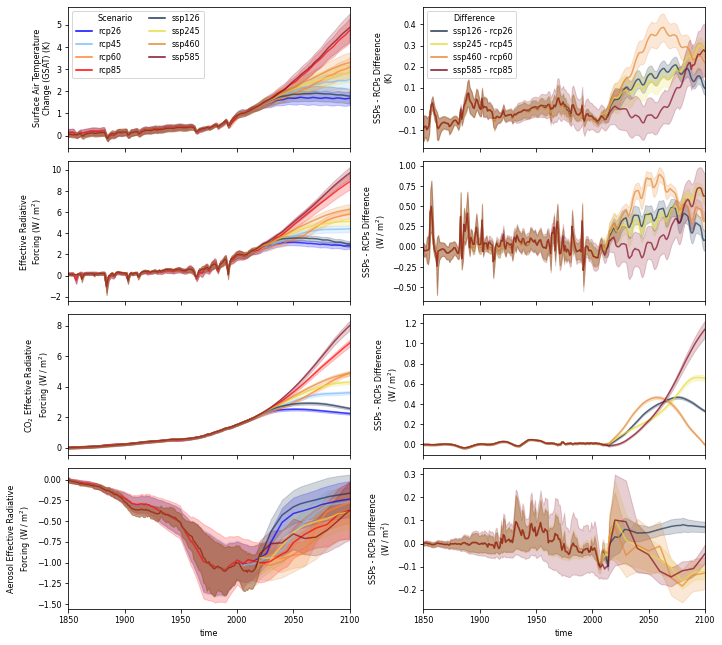

<IPython.core.display.Javascript object>

In [33]:
filters_variables = [
    (
        "Surface Air Temperature\nChange (GSAT)",
        [
            "Surface Air Temperature Change",
            "Surface Air Temperature Change|50th quantile",
        ],
    ),
    (
        "Effective Radiative \nForcing",
        ["Effective Radiative Forcing", "Effective Radiative Forcing|50th quantile"],
    ),
    (
        "CO$_2$ Effective Radiative \nForcing",
        [
            "Effective Radiative Forcing|Anthropogenic|CO2",
            "Effective Radiative Forcing|Anthropogenic|CO2|50th quantile",
        ],
    ),
    (
        "Aerosol Effective Radiative\nForcing",
        [
            "Effective Radiative Forcing|Anthropogenic|Aerosols",
            "Effective Radiative Forcing|Anthropogenic|Aerosols|50th quantile",
        ],
    ),
]
region = "World"
scenario_pairs = [
    ["rcp26", "ssp126"],
    ["rcp45", "ssp245"],
    ["rcp60", "ssp460"],
    ["rcp85", "ssp585"],
]
filters_scenario = [v for sp in scenario_pairs for v in sp]
years = range(1850, 2101)

fig, axes_full = plt.subplots(
    nrows=4, ncols=2, figsize=(10, 9), sharex=True, sharey=False
)

for j, ((var_label, var_filter), axes) in enumerate(zip(filters_variables, axes_full)):
    db_plot = db.filter(
        variable=var_filter,
        scenario=filters_scenario,
        year=years,
        climatemodel=climatemodels,
        region=region,
    )
    db_plot["variable-climatemodel"] = (
        db_plot["variable"] + db_plot["climatemodel"]
    ).values.tolist()

    diffs = []
    for rcp, ssp in scenario_pairs:
        diff_rcp = (
            db_plot.filter(scenario=rcp)
            .timeseries()
            .reset_index(["scenario", "model"], drop=True)
        )
        diff_ssp = (
            db_plot.filter(scenario=ssp)
            .timeseries()
            .reset_index(["scenario", "model"], drop=True)
        )
        diff = (diff_ssp - diff_rcp).dropna(how="all")
        if diff.empty:
            raise ValueError("{}, {}".format(rcp, ssp))
        diff = diff.reset_index()
        diff["model"] = "not required"
        diff["Difference"] = "{} - {}".format(ssp, rcp)
        diff["scenario"] = ssp

        diffs.append(diff)

    diffs = df_append([ScmRun(d) for d in diffs])

    db_plot = db_plot.filter(climatemodel=diffs["climatemodel"].tolist())
    db_plot["Scenario"] = db_plot["scenario"]

    lineplot_kwargs = dict(
        estimator="median",
        ci="sd",
        alpha=0.7,
        legend="brief" if j == 0 else False,
        time_axis="year",
        #         units="variable-climatemodel",
        #         estimator=None,
    )
    db_plot.lineplot(
        hue="Scenario", palette=color_map_scenarios, ax=axes[0], **lineplot_kwargs
    )
    unit = diffs.get_unique_meta("unit", no_duplicates=True).replace(
        "W/m^2", "W / m$^2$"
    )
    axes[0].set_ylabel("{} ({})".format(var_label, unit))
    if j == 0:
        axes[0].legend(ncol=2, loc="upper left")
    axes[0].set_xlim(years[0], years[-1])

    diff_palette = {v: color_map_scenarios[v[:6]] for v in diffs["Difference"]}
    diffs.lineplot(
        hue="Difference", palette=diff_palette, ax=axes[1], **lineplot_kwargs
    )
    axes[1].set_ylabel(
        "SSPs - RCPs Difference\n({})".format(unit)
    )  # \n{}".format(var_label))
    if var_label == "Effective Radiative Forcing":
        axes[1].set_ylim([-1, 1])

    mean = diffs.filter(year=2100).timeseries().mean()  #
    mean.columns = ["Mean"]
    mean.name = "Mean"
    std = diffs.filter(year=2100).timeseries().std()  #
    std.columns = ["Stddev"]
    std.name = "Stddev"
    max_vs = diffs.filter(year=2100).timeseries().max()  #
    max_vs.columns = ["Max"]
    max_vs.name = "Max"
    min_vs = diffs.filter(year=2100).timeseries().min()  #
    min_vs.columns = ["Min"]
    min_vs.name = "Min"

    summary = pd.concat([mean, std, max_vs, min_vs], axis=1)
    print(var_label)
    print(summary)
    print("mean by scenario pair")
    print(diffs.filter(year=2100).timeseries().groupby("Difference").mean())
    print("std by scenario pair")
    print(diffs.filter(year=2100).timeseries().groupby("Difference").std())

plt.tight_layout()
outfile = TAS_COMPARISON_FIGURE_PDF
plt.savefig(outfile)
print(outfile)
plt.show()

time            2100-01-01 00:00:00
Difference                         
ssp126 - rcp26             0.067428
ssp245 - rcp45            -0.133195
ssp460 - rcp60            -0.146461
ssp585 - rcp85            -0.046117

<IPython.core.display.Javascript object>